Даний код складається з двох частин   
Перша спроба через Dense   
Друга через Conv2D

In [1]:
import numpy as np

from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau

from tensorflow.keras.datasets import fashion_mnist

In [2]:
# Створення зворотного виклику для чекпойнтів
checkpoint_cb = ModelCheckpoint("fashion_mnist_model.h5",  # Шлях до файлу, де буде збережена модель
                                save_best_only=True)  # Зберігає тільки ту модель, яка має найкращу точність на валідації
"""
Як альтернатива
import os

checkpoint_dir = "./checkpoints"  # Вкажіть шлях до папки чекпойнтів
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

checkpoint_path = os.path.join(checkpoint_dir, "model_{epoch:02d}-{val_loss:.2f}.h5")
checkpoint_cb = ModelCheckpoint(checkpoint_path, save_best_only=True)
"""

# Завантаження датасету fashion_mnist
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# розділяємо тренувальний набір на тренувальний та валідаційний набори
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2)

x_train = x_train.astype('float32') / 255.0
x_val = x_val.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
# y_train, y_val, y_test не потребують нормалізації

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)

early_stopping_cb = EarlyStopping(
    monitor='val_loss',  # Спостереження за втратами на валідаційному наборі
    patience=5,         # Кількість епох без покращення після яких тренування буде зупинено
    restore_best_weights=True  # Відновлення ваг моделі з найкращої епохи
)

# Визначення кількості унікальних міток у тренувальному наборі
num_classes = len(np.unique(y_train))


In [147]:
from tensorflow.keras.layers import Layer
import tensorflow as tf

class DropConnectDense(Layer):
    def __init__(self, units, activation=None, drop_prob=0.5, **kwargs):
        super(DropConnectDense, self).__init__(**kwargs)
        self.units = units
        self.activation = tf.keras.activations.get(activation)
        self.drop_prob = drop_prob

    def build(self, input_shape):
        self.w = self.add_weight(shape=(input_shape[-1], self.units),
                                 initializer='random_normal',
                                 trainable=True)
        self.b = self.add_weight(shape=(self.units,),
                                 initializer='zeros',
                                 trainable=True)

    def call(self, inputs, training=None):
        if training:
            drop_mask = tf.nn.dropout(tf.ones_like(self.w), rate=self.drop_prob)
            w = tf.multiply(self.w, drop_mask)
        else:
            w = self.w
        z = tf.matmul(inputs, w) + self.b
        return self.activation(z)

"""
Але він ламає чекпоінти
"""

'\nАле він ламає чекпоінти\n'

In [3]:
print(f'x_train shape: {x_train.shape}')
print(f'x_val shape: {x_val.shape}')
print(f'x_test shape: {x_test.shape}')

x_train shape: (48000, 28, 28)
x_val shape: (12000, 28, 28)
x_test shape: (10000, 28, 28)


In [212]:
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.layers import PReLU

model = Sequential()

# Flatten шар перетворює вхідні дані в одновимірний масив
model.add(Flatten(input_shape=(28, 28)))
# model.add(Dense(128, activation='relu'))
#model.add(Dense(256, activation='relu', kernel_regularizer=l2(0.01), name='dense_1'))
model.add(Dense(256, name='dense_1'))
# Додавання PReLU як окремого шару
model.add(PReLU(name='prelu_1'))

#model.add(DropConnectDense(128, activation='relu', drop_prob=0.4))
#model.add(Dropout(0.4))
# model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu', name='dense_2'))
#model.add(DropConnectDense(128, activation='relu', drop_prob=0.5))
#model.add(Dropout(0.3))

model.add(Dense(num_classes, activation='softmax', name='output'))

# Компіляція моделі
model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [213]:
# Перегляд структури моделі
model.summary()

Model: "sequential_47"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_46 (Flatten)        (None, 784)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               200960    
                                                                 
 prelu_1 (PReLU)             (None, 256)               256       
                                                                 
 dense_2 (Dense)             (None, 64)                16448     
                                                                 
 output (Dense)              (None, 10)                650       
                                                                 
Total params: 218314 (852.79 KB)
Trainable params: 218314 (852.79 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [214]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.optimizers import SGD


# Компіляція моделі
model.compile(optimizer=Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# model.compile(optimizer=SGD(learning_rate=0.001, momentum=0.9),
#               loss='sparse_categorical_crossentropy',
#               metrics=['accuracy'])

In [ ]:
history = model.fit(x_train, y_train, 
                    epochs=20,  # кількість епох
                    batch_size=64,  # розмір батчу
                    validation_data=(x_val, y_val),  # валідаційні дані для моніторингу
                    callbacks=[checkpoint_cb, early_stopping_cb, reduce_lr])  # Додавання чекпойнта до тренування

In [229]:
from tensorflow.keras.models import load_model

model = load_model("fashion_mnist_model.h5")

# Продовження тренування
additional_history = model.fit(x_train, y_train, 
                               epochs=additional_epochs,  # загальна кількість епох, включаючи попередні
                               batch_size=64,
                               validation_data=(x_val, y_val),
                               callbacks=[checkpoint_cb])

NameError: name 'additional_epochs' is not defined

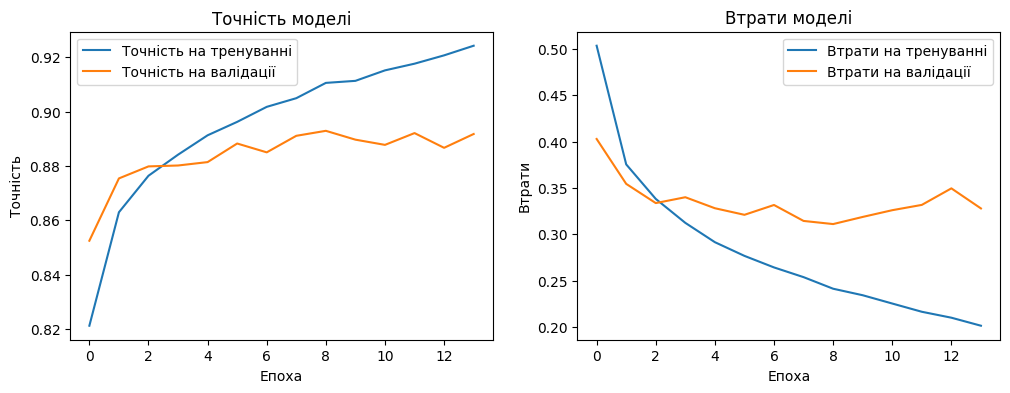

In [217]:
import matplotlib.pyplot as plt

# Графік точності
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Точність на тренуванні')
plt.plot(history.history['val_accuracy'], label='Точність на валідації')
plt.title('Точність моделі')
plt.xlabel('Епоха')
plt.ylabel('Точність')
plt.legend()

# Графік втрат
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Втрати на тренуванні')
plt.plot(history.history['val_loss'], label='Втрати на валідації')
plt.title('Втрати моделі')
plt.xlabel('Епоха')
plt.ylabel('Втрати')
plt.legend()

plt.show()

In [48]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping

# Створення зворотних викликів
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=0.00001, verbose=1)
checkpoint_cb = ModelCheckpoint("model_checkpoint.h5", save_best_only=True)
early_stopping_cb = EarlyStopping(patience=5, restore_best_weights=True)

# Розширення вимірів тренувальних та валідаційних даних
x_train_expanded = np.expand_dims(x_train, axis=-1)  # Додавання виміру каналу
x_val_expanded = np.expand_dims(x_val, axis=-1)


In [49]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [50]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.layers import PReLU

model = Sequential([
    Conv2D(24, kernel_size=(3, 3), input_shape=(28, 28, 1), strides=(2, 2), padding='same', name='conv2d_1'),
    BatchNormalization(),
    PReLU(name='prelu_1'),

    #MaxPooling2D(pool_size=(2, 2)),

    Conv2D(72, kernel_size=(5, 5), strides=(2, 2), padding='same', name='conv2d_2'),
    BatchNormalization(),
    PReLU(name='prelu_2'),

    MaxPooling2D(pool_size=(2, 2)),
    
    Conv2D(216, kernel_size=(5, 5), strides=(2, 2), padding='same', name='conv2d_3'),
    BatchNormalization(),
    PReLU(name='prelu_3'),

    Flatten(name='flatten'),

    Dense(256, name='dense_1'),
    PReLU(name='prelu_4'),
    Dropout(0.3, name='dropout'),

    Dense(num_classes, activation='softmax', name='output')
])


model.compile(optimizer=Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07), 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

In [51]:
# Тренування моделі з додаванням зворотних викликів
history = model.fit(datagen.flow(x_train_expanded, y_train, batch_size=24),
    epochs=35,
    #batch_size=64,
    validation_data=(x_val, y_val),
    callbacks=[checkpoint_cb, early_stopping_cb, reduce_lr]  # Додавання всіх зворотних викликів тут
)

Epoch 1/35
2000/2000 [==============================] - 29s 14ms/step - loss: 0.6886 - accuracy: 0.7392 - val_loss: 0.6077 - val_accuracy: 0.7724 - lr: 0.0010
Epoch 2/35
2000/2000 [==============================] - 28s 14ms/step - loss: 0.5098 - accuracy: 0.8072 - val_loss: 0.3814 - val_accuracy: 0.8553 - lr: 0.0010
Epoch 3/35
2000/2000 [==============================] - 28s 14ms/step - loss: 0.4474 - accuracy: 0.8319 - val_loss: 0.4580 - val_accuracy: 0.8309 - lr: 0.0010
Epoch 4/35
2000/2000 [==============================] - 28s 14ms/step - loss: 0.4152 - accuracy: 0.8434 - val_loss: 0.3369 - val_accuracy: 0.8782 - lr: 0.0010
Epoch 5/35
2000/2000 [==============================] - 28s 14ms/step - loss: 0.3938 - accuracy: 0.8536 - val_loss: 0.4610 - val_accuracy: 0.8177 - lr: 0.0010
Epoch 6/35
2000/2000 [==============================] - 28s 14ms/step - loss: 0.3758 - accuracy: 0.8583 - val_loss: 0.3329 - val_accuracy: 0.8671 - lr: 0.0010
Epoch 7/35
2000/2000 [========================

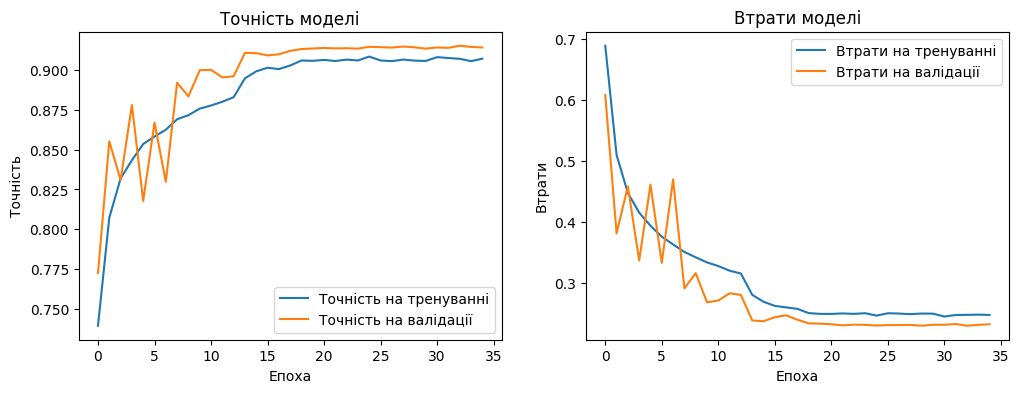

In [52]:
import matplotlib.pyplot as plt

# Графік точності
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Точність на тренуванні')
plt.plot(history.history['val_accuracy'], label='Точність на валідації')
plt.title('Точність моделі')
plt.xlabel('Епоха')
plt.ylabel('Точність')
plt.legend()

# Графік втрат
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Втрати на тренуванні')
plt.plot(history.history['val_loss'], label='Втрати на валідації')
plt.title('Втрати моделі')
plt.xlabel('Епоха')
plt.ylabel('Втрати')
plt.legend()

plt.show()